In [ ]:
!git clone https://github.com/Annaantonin/Myneuraluq.git

In [2]:
# os.chdir("/mnt/")
import  neuraluq.neuraluq as neuq
import neuraluq.neuraluq.variables as neuq_vars
from neuraluq.neuraluq.config import tf

import numpy as np
import scipy.io as sio

from scipy.io import loadmat

import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/Annaantonin/Data.git

In [7]:
import Data as data

In [ ]:
os.listdir(".")

In [3]:
def load_data(noise):

    data = sio.loadmat("Data/sdof_tower.mat")
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["pf"]
    # Input_train=t, x_tt
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train
    n=4000
    return  x_tt_train[0:n], t_train[0:n], x_train[0:n], f_train[0:n]


In [25]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# k_system=27000;
# ksi=0.245;
# m=4500; %mass 
# Uz was computed using logarithmic law, height for the example was taken as 30 m and the roughness length defined as in urban area:
# U(z)=1.37/0.4*np.log(30/2) 

# The constants and the spectrum for the turbulence fluctuations were taken from: Roncallo, L., Solari, G., Muscolino, G., and Tubino, F. “Maximum dynamic response of linear elastic sdof systems based
# on an evolutionary spectral model for thunderstorm outflows”. Journal of Wind Engineering and Industrial Aerodynamics. 224:104978 (2022)

def pde_init(t,  x): # Initial value for the states
    x_t = tf.gradients(x, t)[0]
    return tf.concat([x[0], x_t[0]], axis=-1)

def pde_xtt(t, x, *args): # derivative to get the acceleration
    x_t = tf.gradients(x, t)                                                                                                                                                                                                                        
    x_tt = tf.gradients(x_t, t)
    return x_tt

def pde_fn(t, x, f,  Uz, log_c, log_k): # Equation of motion that returns target acceleration 
    
    Uz=tf.clip_by_value(Uz, clip_value_min=9, clip_value_max=12)
    w = tf.linspace(0.01, 10.0, 1000)  # Frequency array
    phi = tf.random.uniform(shape=[w.shape[0]], minval=0, maxval=2*np.pi, dtype=tf.float32)
    dw = w[1] - w[0]  # Frequency spacing
    Lv = 1.72 #  integral length scale parameter/ 
    S = 6.868 * w * Lv / ((1 + 10.302 * w * Lv) ** (5 / 3))
    Sw = (1.2 * 8 * 0.12 * Uz ** 2) ** 2 * S  # Compute Sw tensor
    cos_term = tf.math.cos(tf.tensordot(w, t[:,0], axes=0) + phi[:, tf.newaxis]) 
    srm_term = tf.sqrt(2 * Sw * dw)[:, tf.newaxis] * cos_term  # Broadcast sqrt_term over t
    f0 = tf.reduce_sum(srm_term, axis=0)  # Reduced turbulence part
    print(f0,'f0')
    f1 = 0.5 * 1.2 * 8 * Uz ** 2  # w_mean part
    output = f0 + f1 # mean part + Reduced  turbulence part 
    output=tf.reshape(output, [-1, 1]) # to match the tensor size
    print(output, 'output')
    m=4500
    # log_c=tf.clip_by_value(log_c,  clip_value_min=-0.1, clip_value_max=0.3)
    # log_k=tf.clip_by_value(log_k, clip_value_min=-0.5, clip_value_max=0.5) # to make constraints for the parameters
    x_t = tf.gradients(x, t) [0] [..., 0:1]     #velocity                                                                                                                                                                                                                   
    x_tt=output-(0.245*tf.exp(log_c)*x_t + 27000*tf.exp(log_k)*x)
    # print(x_tt,'xtt')
    return x_tt/m

def pde_Spec(t,  f, Uz,  *args):  # The funvtion to fit the desired force f into the output of the spectrum
    Uz=tf.clip_by_value(Uz, clip_value_min=9, clip_value_max=12) # slowly-varying mean wind velocity value
    print(Uz,'Uz')
    w = tf.linspace(0.01, 10.0, 1000)  # Frequency array
    phi = tf.random.uniform(shape=[w.shape[0]], minval=0, maxval=2*np.pi, dtype=tf.float32)  # Random phase angles
    dw = w[1] - w[0]  # Frequency spacing
    Lv = 1.72 #  integral length scale parameter/ slowly-varying mean Uz

    S = 6.868 * w * Lv / ((1 + 10.302 * w * Lv) ** (5 / 3)) # Turbulence spectrum 
    Sw = (1.2 * 8 * 0.12 * Uz ** 2) ** 2 * S  # Power spectrum (air density*Area of the structure*drag coefficint)*spectrum of turbulent fluctuations

    cos_term = tf.math.cos(tf.tensordot(w, t[:,0], axes=0) + phi[:, tf.newaxis]) 
    
    srm_term = tf.sqrt(2 * Sw * dw)[:, tf.newaxis] * cos_term  # Spectral representation method (SRM)
    
    f0 = tf.reduce_sum(srm_term, axis=0)  # Reduced turbulence part
   
    f1 = 0.5 * 1.2 * 8 *Uz ** 2  # wind action of a structure -mean part
    output = f0 + f1
    output=tf.reshape(output, [-1, 1]) 
    myoutput = output - f # Attenmpts to match the spectrum output

@neuq.utils.timer
def Trainable(
    x_tt_train, t_train, x_train, f_train, noise, layers,
):
    # build processes
   
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation= tf.math.sin),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# Displacement
    )   
           
    process_f = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation= tf.math.sin),
        posterior=neuq_vars.fnn.Trainable(layers=layers), # Appllied wind force
    ) 
    process_Uz = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=10), #slowly-varying mean wind velocity value
    )
    
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0.1), # Damping ratio
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0.1), # Stiffness ratio
    )
  
    method = neuq.inferences.DEns(
        num_samples=3, num_iterations=50000, optimizer=tf.train.AdamOptimizer(1e-3), 
    )
   
          
    loss_init = neuq.likelihoods.MSE(
        inputs=t_train[0:1],
        targets=[0,0], 
        processes=[process_x], 
        pde=pde_init,
        multiplier=1,
    )
    loss_x = neuq.likelihoods.MSE(  
        inputs=t_train,
        targets=x_tt_train,
        processes=[process_x],
        pde=pde_xtt, 
        multiplier=1,
    )    
    
    loss_fn = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, 
        processes=[process_x, process_f, process_Uz,  process_log_c, process_log_k], 
        pde=pde_fn,
        multiplier=1,
    )
    loss_spectrum = neuq.likelihoods.MSE(   
        inputs=t_train, 
        targets=np.zeros_like(t_train),
        processes=[process_f, process_Uz],
        pde=pde_Spec, 
        multiplier=1e-3,
    )   
    
    likelihoods=[loss_init, loss_x, loss_fn, loss_spectrum]
    processes=[process_x, process_f, process_Uz, process_log_c, process_log_k]
    
    model = neuq.models.Model(
        processes=[process_x, process_f, process_Uz, process_log_c, process_log_k],
        likelihoods=[loss_init,
                     loss_x, 
                     loss_fn, 
                     loss_spectrum],
    )
   
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    processes=processes 
    likelihoods=likelihoods
  
    return processes, samples, model, likelihoods


if __name__ == "__main__":

    noise = 0.1

    x_tt_train, t_train, x_train, f_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 20, 20,  1]
  
    processes, samples, model, likelihoods = Trainable( x_tt_train, t_train, x_train, f_train, noise, layers )

    x_pred, f_pred, Uz_pred, logc_pred, logk_pred= model.predict(t_train, samples, processes, pde_fn=None)
    
plt.plot(t_train,np.mean(x_pred, axis=(0, 2)),label='Predicted displacement')
plt.plot(t_train, x_train,'r',label='Actual displacement')
plt.legend()

# plt.rcParams['figure.figsize'] = [3,3]
# neuq.utils.hist(np.exp(logk_pred).flatten(),  name="value of $k$" )
# neuq.utils.hist(np.exp(logc_pred).flatten(), bins=30,name="value of $c$")

2024-04-15 01:34:47.193427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:34:47.193474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:34:47.193484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:34:47.193635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 01:34:47.193648: I tensorflow/core/co

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Tensor("Sum_27:0", shape=(4000,), dtype=float32) f0
Tensor("Reshape_13:0", shape=(4000, 1), dtype=float32) output
Tensor("clip_by_value_5:0", shape=(), dtype=float32) Uz
Generating 0th sample by deep ensemble...


2024-04-15 01:34:47.622247: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_74/Assign' id:5796 op device:{requested: '', assigned: ''} def:{{{node Variable_74/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_74, Const_214)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  250.99121
Iteration:  1000 , loss:  142.66824
Iteration:  2000 , loss:  119.77935
Iteration:  3000 , loss:  107.15928
Iteration:  4000 , loss:  91.663795
Iteration:  5000 , loss:  89.94382
Iteration:  6000 , loss:  73.921
Iteration:  7000 , loss:  56.955772
Iteration:  8000 , loss:  61.35433
Iteration:  9000 , loss:  42.41047
Iteration:  10000 , loss:  45.693455
Iteration:  11000 , loss:  40.179073
Iteration:  12000 , loss:  25.147606
Iteration:  13000 , loss:  18.819296
Iteration:  14000 , loss:  16.784904
Iteration:  15000 , loss:  12.836451
Iteration:  16000 , loss:  9.611509
Iteration:  17000 , loss:  8.439771
Iteration:  18000 , loss:  5.3372912
Iteration:  19000 , loss:  4.478669
Iteration:  20000 , loss:  4.1965775
Iteration:  21000 , loss:  4.7052455
Iteration:  22000 , loss:  4.2729735
Iteration:  23000 , loss:  4.333055
Iteration:  24000 , loss:  3.7416441
Iteration:  25000 , loss:  4.657709
Iteration:  26000 , loss:  4.2265296
Iteration:  27000 , loss:

2024-04-15 01:37:54.967619: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_2/Assign' id:7263 op device:{requested: '', assigned: ''} def:{{{node beta2_power_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_2, beta2_power_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  130.789
Iteration:  2000 , loss:  115.89672
Iteration:  3000 , loss:  110.44212
Iteration:  4000 , loss:  95.76447
Iteration:  5000 , loss:  83.56116
Iteration:  6000 , loss:  78.89185
Iteration:  7000 , loss:  56.346195
Iteration:  8000 , loss:  61.963413
Iteration:  9000 , loss:  47.694836
Iteration:  10000 , loss:  34.65072
Iteration:  11000 , loss:  35.78369
Iteration:  12000 , loss:  28.890804
Iteration:  13000 , loss:  22.895895
Iteration:  14000 , loss:  15.321884
Iteration:  15000 , loss:  9.199266
Iteration:  16000 , loss:  9.557074
Iteration:  17000 , loss:  8.077512
Iteration:  18000 , loss:  5.339642
Iteration:  19000 , loss:  4.8116217
Iteration:  20000 , loss:  3.5103452
Iteration:  21000 , loss:  3.4330611
Iteration:  22000 , loss:  3.6485438
Iteration:  23000 , loss:  5.0206456
Iteration:  24000 , loss:  4.0053735
Iteration:  25000 , loss:  3.6728535
Iteration:  26000 , loss:  4.967213
Iteration:  27000 , loss:  3.9172137
Iteration:  28000 , lo

2024-04-15 01:40:59.990068: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_2/Assign' id:7263 op device:{requested: '', assigned: ''} def:{{{node beta2_power_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_2, beta2_power_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  153.71103
Iteration:  2000 , loss:  118.12027
Iteration:  3000 , loss:  107.82997
Iteration:  4000 , loss:  107.759026
Iteration:  5000 , loss:  85.62217
Iteration:  6000 , loss:  76.38189
Iteration:  7000 , loss:  63.216293
Iteration:  8000 , loss:  54.416733
Iteration:  9000 , loss:  46.313217
Iteration:  10000 , loss:  45.017258
Iteration:  11000 , loss:  36.603867
Iteration:  12000 , loss:  24.068531
Iteration:  13000 , loss:  24.653124
Iteration:  14000 , loss:  16.130136
Iteration:  15000 , loss:  15.816766
Iteration:  16000 , loss:  15.553947
Iteration:  17000 , loss:  10.593931
Iteration:  18000 , loss:  6.7250986
Iteration:  19000 , loss:  5.924413
Iteration:  20000 , loss:  4.8966
Iteration:  21000 , loss:  3.7599216
Iteration:  22000 , loss:  4.159501
Iteration:  23000 , loss:  4.272524
Iteration:  24000 , loss:  3.2090309
Iteration:  25000 , loss:  4.3387756
Iteration:  26000 , loss:  4.0042553
Iteration:  27000 , loss:  3.9904826
Iteration:  28000

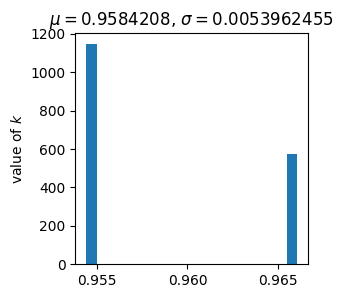

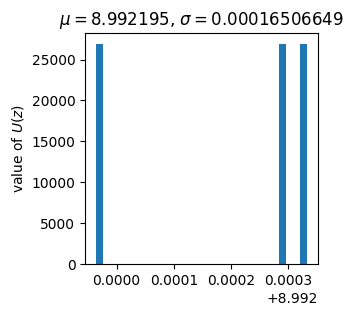

In [26]:
# Plotting the values of interest 
plt.rcParams['figure.figsize'] = [3,3]
neuq.utils.hist(np.exp(logk_pred).flatten(),  name="value of $k$" ) # True must be 1
neuq.utils.hist(np.exp(logc_pred).flatten(), bins=30,name="value of $c$") # True must be 1
neuq.utils.hist(Uz_pred.flatten(), bins=30,  name="value of $U(z)$")# True must be 9.27

In [27]:
# Objective function with revised sizes in order to plot the identified processes

def pde_fn(t, x, f,  Uz, log_c, log_k):
    
    Uz=Uz[0,:,0]
    w = tf.linspace(0.01, 10.0, 1000)  # Frequency array
    phi = tf.random.uniform(shape=[w.shape[0]], minval=0, maxval=2*np.pi, dtype=tf.float32)
    dw = w[1] - w[0]  # Frequency spacing
    Lv = 1.72
    S = 6.868 * w * Lv / ((1 + 10.302 * w * Lv) ** (5 / 3))
    Sw = (1.2 * 8 * 0.12 * Uz ** 2) ** 2 * S  # Compute Sw tensor
    cos_term = tf.math.cos(tf.tensordot(w, t[0,:,0], axes=0) + phi[:, tf.newaxis]) 
    srm_term = tf.sqrt(2 * Sw * dw)[:, tf.newaxis] * cos_term  # Broadcast sqrt_term over t
    print(srm_term)
    f0 = tf.reduce_sum(srm_term, axis=0)  # Reduced turbulence part
    print(f0,'f0')
    f1 = 0.5 * 1.2 * 8 * Uz ** 2  # w_mean part
    output = f0 + f1
    output=tf.reshape(output, [-1, 1]) 
    print(output, 'output')
    # myoutput = output - f # Ensure f is subtracted correctly
    m=4500
    # log_c=tf.clip_by_value(log_c,  clip_value_min=-0.1, clip_value_max=0.3)
    # log_k=tf.clip_by_value(log_k, clip_value_min=-0.5, clip_value_max=0.5) # to make constraints for the parameters
    x_t = tf.gradients(x, t) [0] [..., 0:1]     #velocity                                                                                                                                                                                                                   
    x_tt=output-(0.245*tf.exp(log_c)*x_t + 27000*tf.exp(log_k)*x)
    # x_tt =f-(0.12 * x_t + 700 * x)
    # return [f,x_tt]
    print(x_tt,'xtt')
    return x_tt/m # Acceleration

def pde_Spec(t,  x, f, Uz,  *args):
    w = tf.linspace(0.01, 10.0, 1000)  # Frequency array, example values
    phi = tf.random.uniform(shape=[w.shape[0]], minval=0, maxval=2*np.pi, dtype=tf.float32)
    dw = w[1] - w[0]  # Frequency spacing
    # print(t)
    Uz=Uz[0,:,0]
    Lv = 1.72 # coefficient from thunderstorm records
    print(Uz)
    S = 6.868 * w * Lv / ((1 + 10.302 * w * Lv) ** (5 / 3)) # Turbulence spectrum
    Sw = (1.2 * 8 * 0.12 * Uz ** 2) ** 2 * S  # Power spectrum 

    cos_term = tf.math.cos(tf.tensordot(w, t[0,:,0], axes=0) + phi[:, tf.newaxis]) 
    print(cos_term)
    
    srm_term = tf.sqrt(2 * Sw * dw)[:, tf.newaxis] * cos_term  # Broadcast sqrt_term over t
    
    f0 = tf.reduce_sum(srm_term, axis=0)  # Reduced turbulence part
   
    f1 = 0.5 * 1.2 * 8 *Uz ** 2  # w_mean part
    output = f0 + f1
    output=tf.reshape(output, [-1, 1]) 
    myoutput = output - f # Ensure f is subtracted correctly
    print(myoutput, 'result')
    return myoutput # Should be reduced to zero


In [40]:
(ff_pred, )=model.predict(t_train, samples, processes, pde_fn=pde_Spec)

Tensor("strided_slice_171:0", shape=(1,), dtype=float32)
Tensor("Cos_18:0", shape=(1000, 4000), dtype=float32)
Tensor("sub_49:0", shape=(3, 4000, 1), dtype=float32) result


Tensor("mul_196:0", shape=(1000, 4000), dtype=float32)
Tensor("Sum_37:0", shape=(4000,), dtype=float32) f0
Tensor("Reshape_16:0", shape=(4000, 1), dtype=float32) output
Tensor("sub_45:0", shape=(3, 4000, 1), dtype=float32) xtt


Text(0, 0.5, 'Acceleration $ (m/s^2)$')

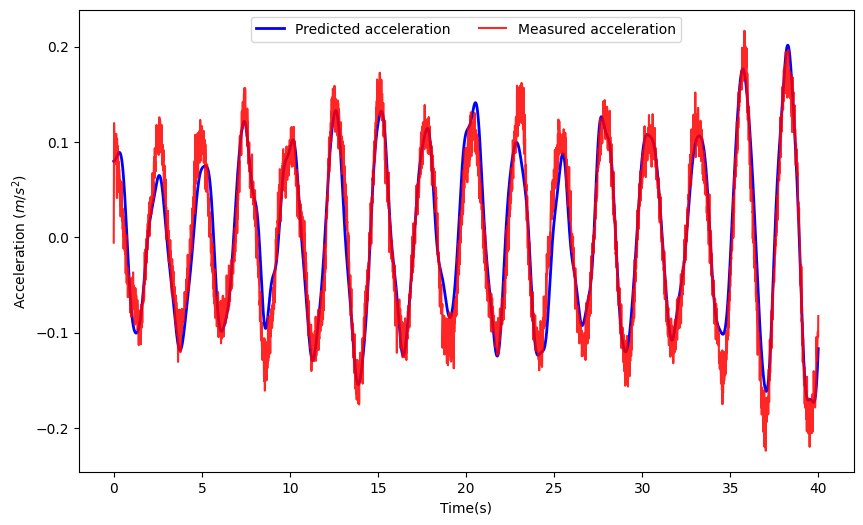

In [29]:
(xtt_pred,) = model.predict(t_train, samples, processes, pde_fn=pde_fn)
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot(t_train, np.mean(xtt_pred, axis=(0,2)), 'b', linewidth=2, label='Predicted acceleration')
plt.plot(t_train, x_tt_train,'r', label='Measured acceleration',alpha=0.85)
plt.legend(loc='upper center', ncol=2)
plt.xlabel('Time(s)')
plt.ylabel('Acceleration $ (m/s^2)$')
# plt.savefig('SDOF acceleration known')

In [47]:
f_std = np.std(ff_pred, axis=(0))
f_pred.shape

(3, 4000, 1)

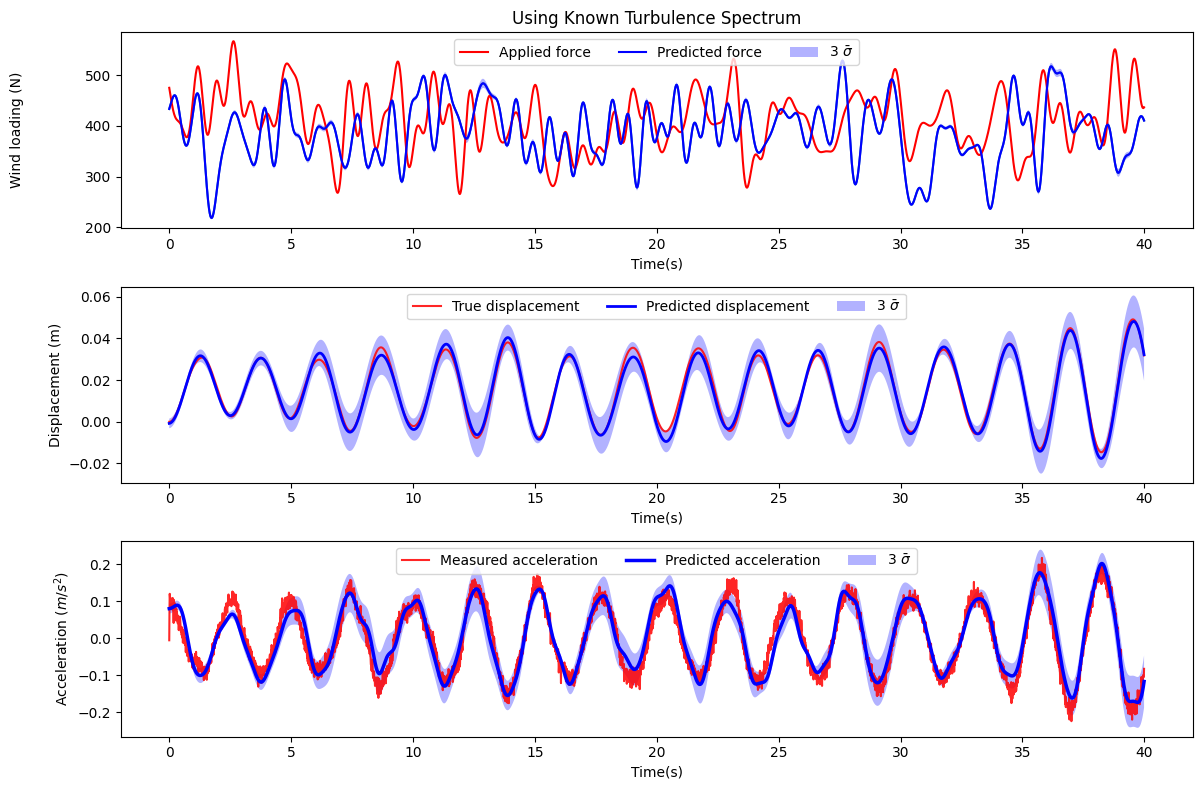

In [49]:


f_mean = np.mean(ff_pred+f_pred, axis=(0,2))
# f_std = np.std(f_pred+ff_pred, axis=0)
f_std = np.std(f_pred, axis=(0,2))
# accelerations
xtt_mean = np.mean(xtt_pred, axis=(0,2))
xtt_std = np.std(xtt_pred, axis=(0,2))
# displacement
x_mean = np.mean(x_pred, axis=(0,2))
x_std = np.std(x_pred, axis=(0,2))
# xtt_std.shape
# Create a 3x1 subplot
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
axs[0].plot(t_train.flatten(), f_mean, 'tab:blue')
axs[0].plot(t_train, f_train, 'r', label='Applied force')
axs[0].plot(t_train, f_mean, "b", label="Predicted force")
axs[0].fill_between(t_train.flatten(),
                 f_mean.flatten() - 3 * np.sqrt(f_std.flatten()**2), 
                 f_mean.flatten() + 3 * np.sqrt(f_std.flatten()**2), alpha=0.3,facecolor="b", label="3 $\\bar{\\sigma}$")

axs[0].set_title('Using Known Turbulence Spectrum')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Wind loading (N)')
axs[0].legend(loc='upper center', ncol=3)
# axs[0].set_ylim(100, 700) 
# axs[0].set_xlim(0, 40) 
axs[0].yaxis.set_label_coords(-0.09, 0.5)

axs[1].plot(t_train.flatten(), x_train,'r', label='True displacement', alpha=0.85)
axs[1].plot(t_train.flatten(), x_mean, 'b', linewidth=2, label='Predicted displacement')
axs[1].fill_between(t_train.flatten(),
                 x_mean.flatten() - 3 * np.sqrt(x_std.flatten()**2), 
                 x_mean.flatten() + 3 * np.sqrt(x_std.flatten()**2), alpha=0.3, facecolor="b", label="3 $\\bar{\\sigma}$")
axs[1].set_xlabel('Time(s)')
axs[1].set_ylabel('Displacement (m)')
axs[1].legend(loc='upper center', ncol=3)
# Tangent Function
# axs[1].set_xlim(0, 40) 
# axs[0].set_ylim(100, 700)

axs[2].plot(t_train, x_tt_train,'r', label='Measured acceleration',alpha=0.85)
axs[2].plot(t_train, xtt_mean, 'b', linewidth=2.5, label='Predicted acceleration')
axs[2].fill_between(t_train.flatten(),
                 xtt_mean.flatten() - 3 * np.sqrt(xtt_std.flatten()**2), 
                 xtt_mean.flatten() + 3 * np.sqrt(xtt_std.flatten()**2), alpha=0.3,
facecolor="b",
label="3 $\\bar{\\sigma}$")
axs[2].set_xlabel('Time(s)')
axs[2].set_ylabel('Acceleration $ (m/s^2)$')
axs[2].legend(loc='upper center', ncol=3)
# axs[2].set_ylim(-0.3, 0.4) 
# axs[2].set_xlim(0, 40)  # Limit y-axis to avoid extreme values affecting visualization

plt.tight_layout()
plt.show()